In [1]:
import numpy as onp
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import corner

In [2]:
import jax 
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax.nn import relu, elu
import optax 

from jax import random

# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

In [3]:
data = pd.read_csv('Data/mesa_data.csv')
data.head()

Unnamed: 0  filename  model_number  evol_stage  initial_mass  \
0           0  profile4         152.0         0.0           0.8   
1           1  profile5         153.0         0.0           0.8   
2           2  profile6         154.0         0.0           0.8   
3           3  profile7         155.0         0.0           0.8   
4           4  profile8         156.0         0.0           0.8   

   initial_Yinit  initial_Zinit  initial_feh  initial_MLT  initial_fov  ...  \
0           0.32       0.036803          0.5          2.1          0.0  ...   
1           0.32       0.036803          0.5          2.1          0.0  ...   
2           0.32       0.036803          0.5          2.1          0.0  ...   
3           0.32       0.036803          0.5          2.1          0.0  ...   
4           0.32       0.036803          0.5          2.1          0.0  ...   

     E_0_36    E_0_37    E_0_38        E_0_39        E_0_40        tau_he  \
0  0.000006  0.000002  0.000001  7.889056e-07  6.149682e-07  15247.850269   
1  0.000008  0.000002  0.000001  8.212464e-07  6.273383e-07  14809.891105   
2  0.000013  0.000003  0.000001  8.515127e-07  6.398741e-07  14496.838617   
3  0.000018  0.000003  0.000001  8.790797e-07  6.513090e-07  14220.559706   
4  0.000027  0.000003  0.000001  9.036751e-07  6.612813e-07  14054.932771   

      delta_he    amp_he        tau_cz  \
0  2037.139686  0.029961  38796.631185   
1  1980.528826  0.029540  37900.327592   
2  1940.585790  0.029221  37222.634389   
3  1878.217087  0.028561  36703.539749   
4  1883.449431  0.028860  36302.082709   

                                            dirname  
0  m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1  
1  m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1  
2  m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1  
3  m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1  
4  m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1  

[5 rows x 116 columns]

In [4]:
print(len(data))
data = data[data.star_age > 0.2]
data = data[data.effective_T < 6800]
data = data[data.nu_max > 600]
len(data)

253072


59785

In [166]:
icols = ['initial_mass',
 'initial_Yinit',
 'initial_feh',
 'initial_MLT',
 'frac_age']

ocols = ['effective_T',
 'radius',
 'delta_nu',
 'nu_max']

fcols = [f'nu_0_{n}' for n in range(12, 28)]

cols = fcols + icols + ocols

dfc = data.copy()
dfc.loc[:, ocols + fcols] = onp.log10(data[ocols + fcols])
dfc = dfc[cols]

In [167]:
xs = dfc[icols].values
ys = dfc[fcols + ocols].values

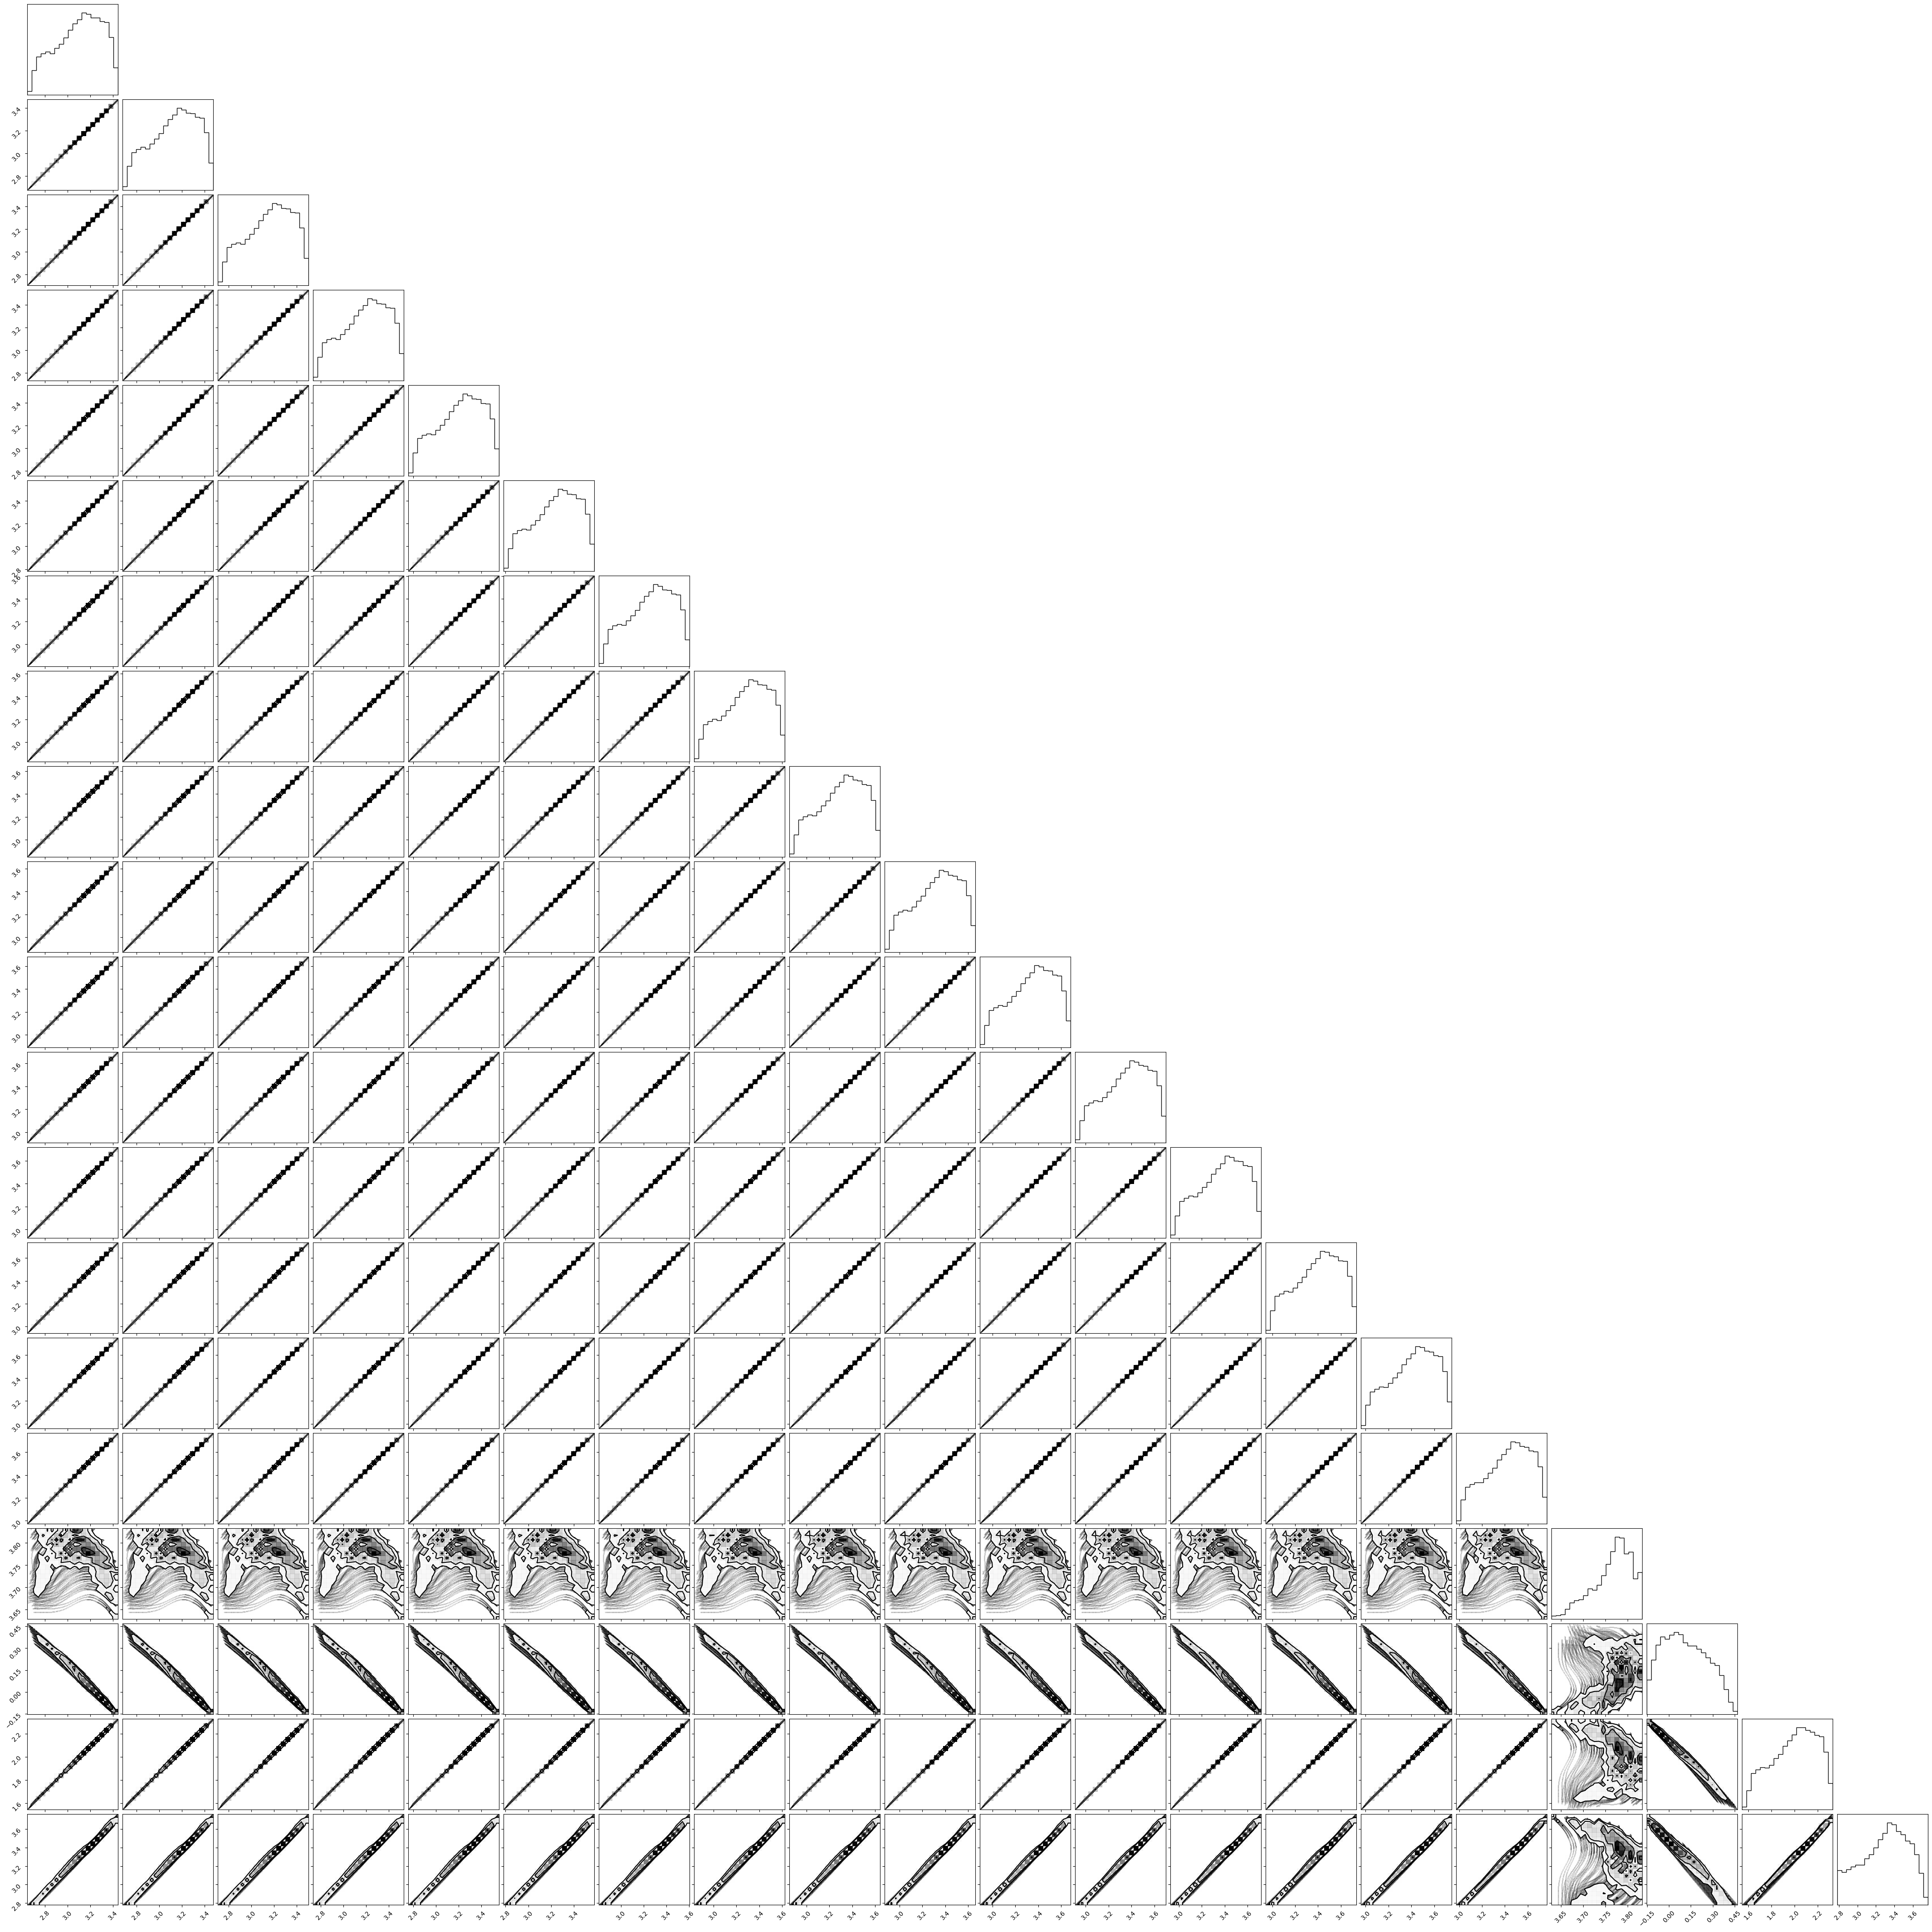

In [168]:
corner.corner(ys);

In [76]:
from functools import partial

class pcann():
    def __init__(self, 
                 layer_sizes=[3, 5, 5, 2], 
                 key=random.PRNGKey(1)):
        self.params = self.initialize_mlp(layer_sizes, key)
        self.batch_forward = vmap(self.forward_pass, in_axes=(None, 0))
        
        
    def init_pca(self, n_components=4):
        self.pca = PCA(n_components=n_components)
        
    def fit_pca(self, ys):
        self.pca.fit(ys)
        print(f'PCA explained variance : {self.pca.explained_variance_ratio_}')
        print(f'PCA total explained variance : {sum(self.pca.explained_variance_ratio_)}')
        self.pca_comp = self.pca.components_
        self.pca_mean = self.pca.mean_
    
    def train(self, xs, ys, 
              lr=1e-1,
              epochs=100, 
              verbose=True,
              recompile=True):
        if recompile:
            self.initialize_opt(lr=lr)
        for i in range(epochs):
            grads = jax.grad(self.loss)(self.params, xs, ys)
            updates, self.opt_state = self.optimizer.update(grads, self.opt_state)
            self.params = optax.apply_updates(self.params, updates)
            if i%(epochs / 10) == 0 and verbose:
                print(f'Epoch {i}: Loss is {self.loss(self.params, xs, ys)}')
        
    def initialize_opt(self, lr=2e-2):
        self.optimizer = optax.adam(lr, b1=0.999)
        #self.optimizer = optax.sgd(lr)
        self.opt_state = self.optimizer.init(self.params)
        
    def pred(self, params, x):
        return self.batch_forward(params, x)
        
    @partial(jit, static_argnums=(0,))
    def loss(self, params, x, y):
        preds = self.pred(params, x)
        loss = np.mean(optax.l2_loss(preds, y))
        return loss
        
    def forward_pass(self, params, x):
        """ Compute the forward pass for each example individually """
        activations = x

        # Loop over the hidden layers
        for w, b in params[:-1]:
            outputs = np.dot(w, activations) + b  # apply affine transformation
            activations = elu(outputs)  #  apply nonlinear activation

        # Perform final mlp output
        w, b = params[-1]
        outputs = (np.dot(w, activations) + b)
        
        # Add pca inverse transform to the output
        final_outputs = np.dot(outputs, self.pca_comp) + self.pca_mean
        return final_outputs
        
    def initialize_mlp(self, sizes, key):
        """ Initialize the weights of all layers of a linear layer network """
        keys = random.split(key, len(sizes))
        # Initialize a single layer with Gaussian weights -  helper function
        def initialize_layer(m, n, key, scale=1e-2):
            w_key, b_key = random.split(key)
            return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
        return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

In [94]:
pca_n_comps = 5
nn = pcann(layer_sizes = [len(icols), 64, 64, 64, 64, pca_n_comps])
nn.init_pca(n_components=pca_n_comps)
nn.fit_pca(ys)

PCA explained variance : [9.96084387e-01 2.65363969e-03 1.15651888e-03 1.00952647e-04
 2.15351113e-06]
PCA total explained variance : 0.9999976515067809


In [98]:
%%time
nn.train(np.asarray(xs), np.asarray(ys), lr=5e-4, epochs=200)

Epoch 0: Loss is 0.003035937435925007
Epoch 20: Loss is 0.002376392250880599
Epoch 40: Loss is 0.00234749517403543
Epoch 60: Loss is 0.0024744293186813593
Epoch 80: Loss is 0.0023787866812199354
Epoch 100: Loss is 0.0023417030461132526
Epoch 120: Loss is 0.002267425647005439
Epoch 140: Loss is 0.002257324056699872
Epoch 160: Loss is 0.0022078186739236116
Epoch 180: Loss is 0.002280485350638628
CPU times: user 36.4 s, sys: 5.35 s, total: 41.7 s
Wall time: 12.1 s


In [162]:
preds = nn.pred(nn.params, xs)

0.0011466728
0.00045013427734375
0.00037860870361328125
0.00034880638122558594
0.0003216266632080078
0.00030994415283203125
0.0003249645233154297
0.00033211708068847656
0.0003266334533691406
0.0003249645233154297
0.0003123283386230469
0.0002999305725097656
0.0002884864807128906
0.00027751922607421875
0.000278472900390625
0.00030875205993652344
0.0003705024719238281
0.00041294097900390625
0.0002976730465888977
0.0004642009735107422
0.0004687309265136719


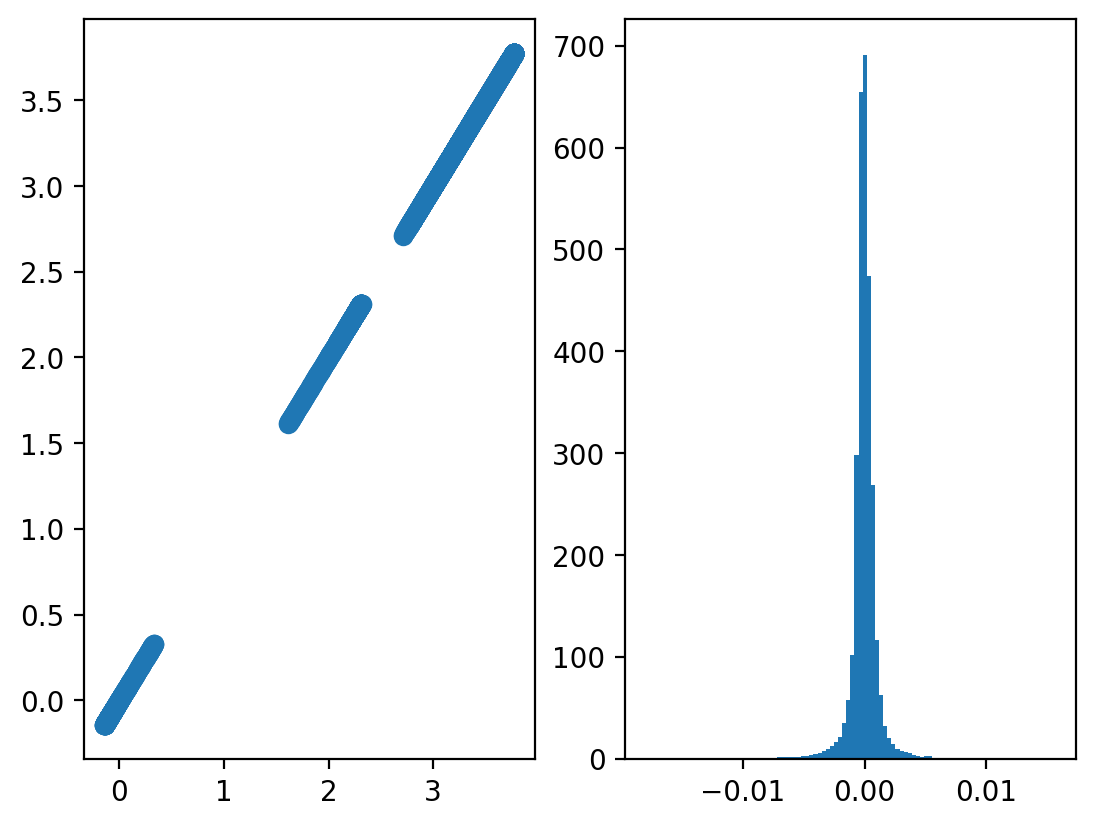

In [163]:
fig, ax = plt.subplots(1, 2, dpi=200)

n = 1000

ax[0].scatter(ys[:n, ...], preds[:n, ...])

ax[1].hist(onp.array(ys[:, 1] - preds[:, 1]), bins=100, density=True);
print(onp.std(onp.array(ys[:, 1] - preds[:, 1])))

from scipy import stats
for i in range(len(ys[0, :])):
    print(stats.median_abs_deviation(onp.array(ys[:, i] - preds[:, i])))

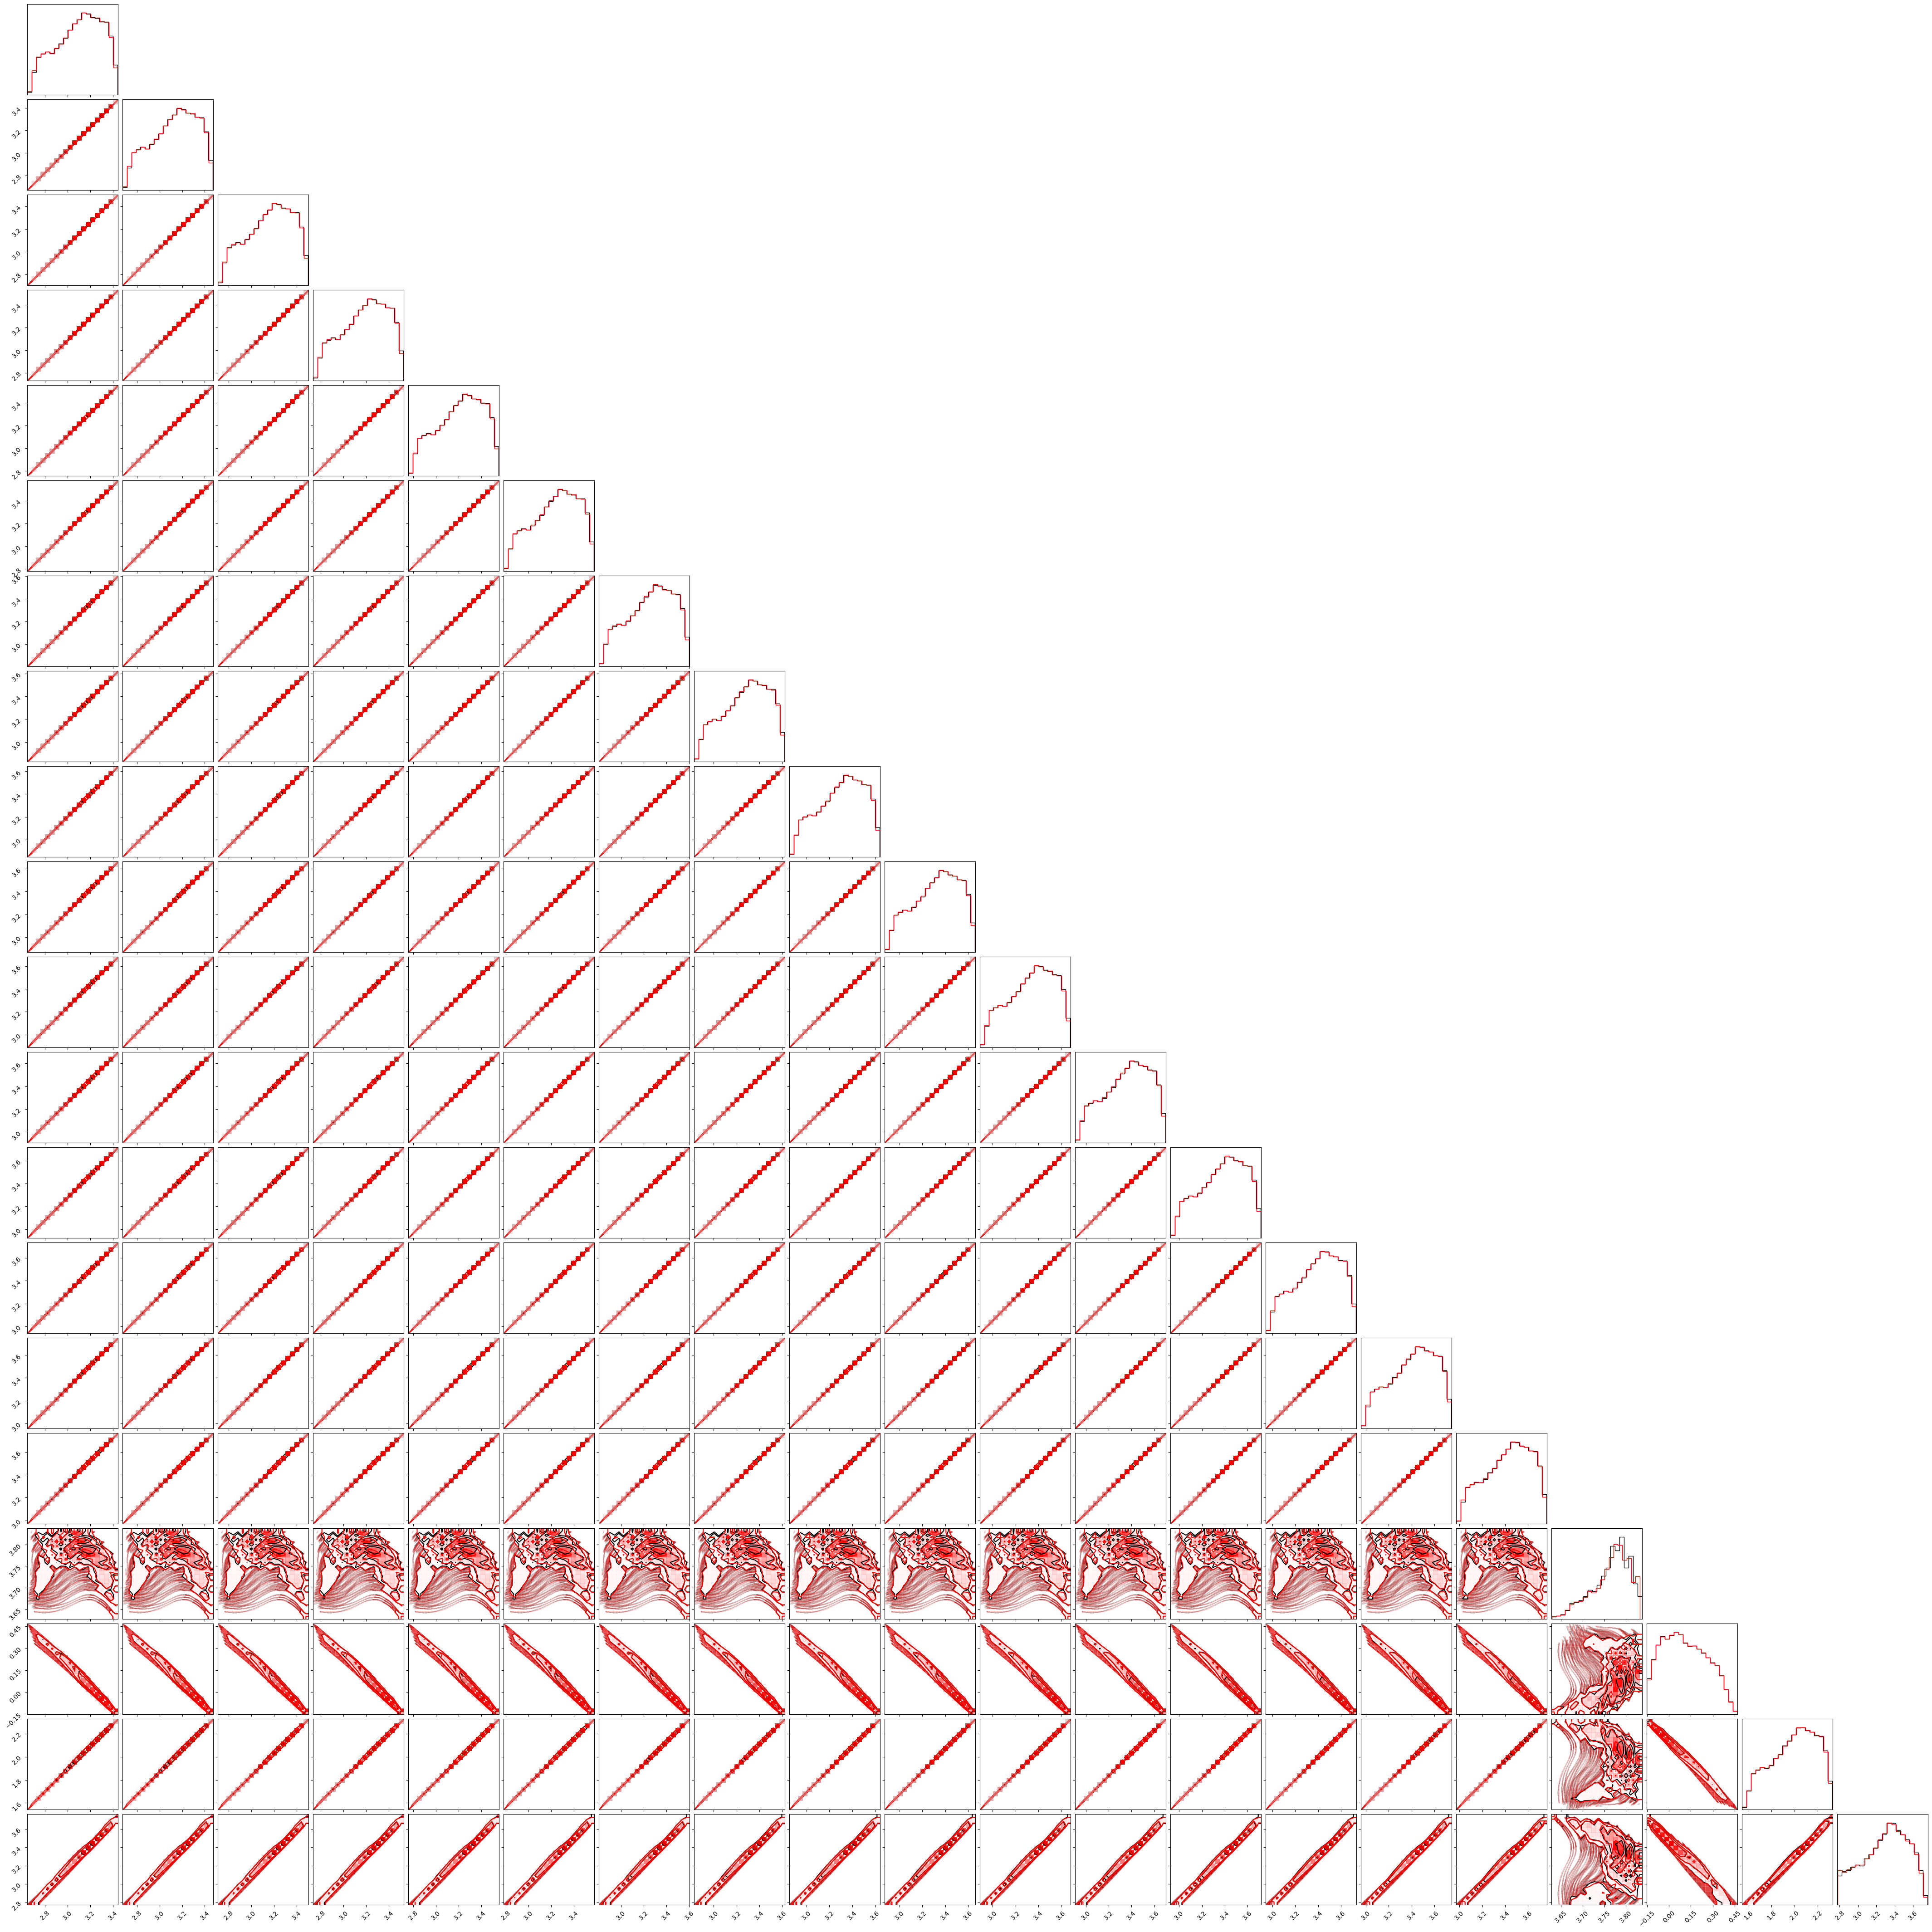

In [164]:
fig = corner.corner(onp.array(preds), color='k');
corner.corner(onp.array(ys), fig=fig, color='r');

In [161]:
nn.train(np.asarray(xs), np.asarray(ys), epochs=30000, recompile=False)

Epoch 0: Loss is 7.395029797407915e-07
Epoch 3000: Loss is 7.300200763893372e-07
Epoch 6000: Loss is 7.207530074992974e-07
Epoch 9000: Loss is 7.125989327505522e-07
Epoch 12000: Loss is 7.055513151499326e-07
Epoch 15000: Loss is 6.964411340959487e-07
Epoch 18000: Loss is 6.885952075208479e-07
Epoch 21000: Loss is 6.823984222137369e-07
Epoch 24000: Loss is 6.750149168510688e-07
Epoch 27000: Loss is 6.688290454803791e-07


In [116]:
print(nn.params)

[(DeviceArray([[ 9.20481384e-02,  3.84269953e-01, -5.38516104e-01,
              -1.21957004e-01,  7.65198395e-02,  2.56171376e-01],
             [-5.11429846e-01,  2.43348721e-02,  3.79512906e-01,
               3.33498535e-03,  2.23739073e-02,  3.24850157e-02],
             [ 9.85280424e-02,  3.25750262e-01, -6.01037741e-01,
              -3.64811346e-02,  4.82176803e-02,  2.73646474e-01],
             [ 5.27295887e-01,  4.46610212e-01, -8.72187555e-01,
               2.79786378e-01, -2.94128627e-01,  8.22127983e-02],
             [ 2.78852016e-01,  6.31129503e-01, -4.47860479e-01,
               1.02627855e-02, -1.69735868e-05,  2.22496077e-01],
             [ 7.43098706e-02,  3.00316930e-01, -7.16488898e-01,
              -1.10892825e-01, -2.98739094e-02,  1.81301892e-01],
             [ 1.38161123e-01,  2.62020767e-01, -7.73640692e-01,
              -1.68043002e-01, -1.43180370e-01,  1.33432552e-01],
             [ 2.73852438e-01,  4.23941046e-01, -8.43568623e-01,
               2

[0.8        0.32       0.5        2.1        0.00986245]


(6400.0, 5000.0)

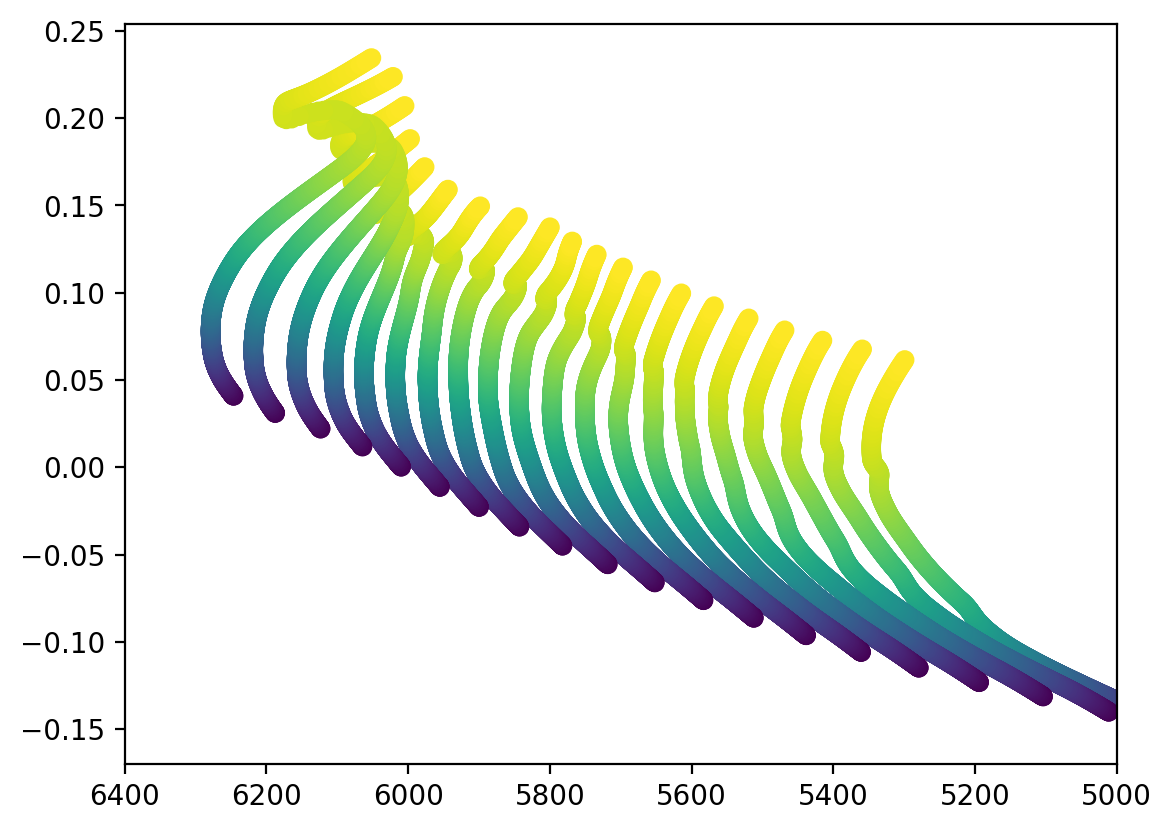

In [173]:
print(xs[0, :])
fage = onp.arange(0, 1.1, 0.001)
fig, ax = plt.subplots(dpi=200)

for m in np.arange(0.8, 1.2, 0.02):
    isoinput = [[m, 0.27, 0.02, 0.0, 2.1, n] for n in fage]
    isochrone = nn.pred(nn.params, np.asarray(isoinput))


    ax.scatter(10**(isochrone[:, -4]), isochrone[:, -3], c=fage)
ax.set_xlim([6400, 5000])